Content

- [Data Reshaping and Preprocessing](Part2(RNNs).ipynb#Preprocessing-&-Creating-Sequences)
- [GRU Model](Part2(RNNs).ipynb#GRU-Model)
    - [Preditcion & Evaluation](Part2(RNNs).ipynb##GRU-Predictions)
- [LSTM Model](Part2(RNNs).ipynb#LSTM-Model)
    - [Preditcion & Evaluation](Part2(RNNs).ipynb##LSTM-Predictions)
- [CNN Model](Part2(RNNs).ipynb#CNN-Model)
    - [Preditcion & Evaluation](Part2(RNNs).ipynb##CNN-Predictions)
- [Comparing Model's Performances](Part2(RNNs).ipynb#Model-Comparaison)

For this file the goal was to predict using 1day info backwards to next Hour for the prices of each state, therefor i proposed 3 different models which are : 

GRU

LSTM

CNN

The file contains an automated code to train all the variables for each model,collect the loss evolutions, predict the test data then plot a comparaison graph between actual real values and predicted ones

The file also contains a comparaison between the performance of the 3 models including loss graph comparaison and real vs predicted plots

The best model was the GRU model it gave the minimum  loss and mse and fitted more the data in the graphs

The choice of the hyperparameters :

- layers : i tried to go as simple as i could due to high computation needed and based on other  works 2 layers should be enough
- Epochs : using 100 epochs gives room to  train for enough time and also the epochs were supervised by early stopping
- activation function = linear (regression)
- number of hidden units = to not go very complex 
- loss  function = mean squared error for regression task
The CNN was just an experiment to not only use RNNs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
sns.set_theme(style="darkgrid")
import warnings

# Ignore all warnings
warnings.simplefilter("ignore")

In [3]:
df = pd.read_csv("data.csv")

In [4]:
df = df.drop(columns=df.columns[1::2])

# Convert 'date_time' to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

<p style="text-align:center; font-size:30px; font-weight:bold;">Preprocessing & Creating Sequences</p>

In [5]:
for col in df.columns[1:]:
    µ = df[col].mean()
    sigma = df[col].std()
    df[col] = df[col].apply(lambda x: (x - µ) / sigma)

In [6]:
df.head(2)

,date_time,price_new_south_wales,price_queensland,price_south_australia,price_tasmania,price_victoria
0,2023-01-01 00:05:00,0.150761,0.143184,0.119746,4.557150,0.673188
1,2023-01-01 00:10:00,0.128921,0.132299,0.107847,0.713072,0.630040


In [7]:
history = 288 #12*24 288 past observations ==> one day backwards 
future = 12 #12*5 12 futere observations ==> one hour backwards

def transform_dataset(input_length, output_length, data):
    df_transformed = data.copy()
    for col in df.columns[1:]:
        # x columns
        for i in range(input_length):
            df_transformed[f'x_{col}_{i}'] = df[col].shift(-i)

        # y columns
        for j in range(output_length):
            df_transformed[f'y_{col}_{j}'] = df[col].shift(-output_length - j)

    df_transformed = df_transformed.dropna(axis=0)
    return df_transformed

full_data = transform_dataset(history, future, df)

In [8]:
full_data.head(3)

,date_time,price_new_south_wales,price_queensland,price_south_australia,price_tasmania,price_victoria,x_price_new_south_wales_0,x_price_new_south_wales_1,x_price_new_south_wales_2,x_price_new_south_wales_3,...,y_price_victoria_2,y_price_victoria_3,y_price_victoria_4,y_price_victoria_5,y_price_victoria_6,y_price_victoria_7,y_price_victoria_8,y_price_victoria_9,y_price_victoria_10,y_price_victoria_11
0,2023-01-01 00:05:00,0.150761,0.143184,0.119746,4.557150,0.673188,0.150761,0.128921,0.081579,0.078154,...,0.337283,0.357911,0.330347,0.326113,0.469970,0.368000,0.370342,0.374936,0.349354,0.330707
1,2023-01-01 00:10:00,0.128921,0.132299,0.107847,0.713072,0.630040,0.128921,0.081579,0.078154,0.078154,...,0.357911,0.330347,0.326113,0.469970,0.368000,0.370342,0.374936,0.349354,0.330707,0.304134
2,2023-01-01 00:15:00,0.081579,0.090857,0.078325,0.573943,0.512217,0.081579,0.078154,0.078154,0.039358,...,0.330347,0.326113,0.469970,0.368000,0.370342,0.374936,0.349354,0.330707,0.304134,0.320979


creating the train and test data sets

In [9]:
# Create train sequences for each series
xtrain_dict = {}
ytrain_dict = {}

for col in df.columns[1:]:
    x_col = full_data[[f'x_{col}_{i}' for i in range(history)]].values
    y_col = full_data[[f'y_{col}_{j}' for j in range(future)]].values

    # Reshape arrays
    xtrain_dict[col] = x_col.reshape(-1, 1, history)
    ytrain_dict[col] = y_col



In [11]:
# Splitting by indexes
train_ratio = 0.75
xtrain_dict_split, xtest_dict, ytrain_dict_split, ytest_dict = {}, {}, {}, {}

for col in df.columns[1:]:
    split_index = int(len(xtrain_dict[col]) * train_ratio)

    xtrain_dict_split[col] = xtrain_dict[col][:split_index]
    xtest_dict[col] = xtrain_dict[col][split_index:]
    ytrain_dict_split[col] = ytrain_dict[col][:split_index]
    ytest_dict[col] = ytrain_dict[col][split_index:]

Defining the models 

In [13]:
def gru(history, future):
    model = Sequential()
    model.add(tf.keras.Input(shape=(xtrain_dict_split["price_new_south_wales"].shape[1], xtrain_dict_split["price_new_south_wales"].shape[2])))
    model.add(GRU(64, return_sequences=True, activation='relu'))
    model.add(GRU(32, return_sequences=False, activation='relu'))
    model.add(Dense(future))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [14]:
def lstm(history, future):
    model = Sequential()
    model.add(tf.keras.Input(shape=(xtrain_dict_split["price_new_south_wales"].shape[1], xtrain_dict_split["price_new_south_wales"].shape[2])))
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(64, return_sequences=False, activation='relu'))
    model.add(Dropout(.4))
    # model.add(Dense(32,activation = "relu"))
    model.add(Dense(future))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

<p style="text-align:center; font-size:40px; font-weight:bold;">GRU Model</p>

In [15]:
for col_to_predict in df.columns[1:]: 
    print(f"Training model for {col_to_predict}...")
    model = gru(history, future)


    hist_gru = model.fit(xtrain_dict_split[col_to_predict], ytrain_dict_split[col_to_predict],
                         epochs=30, batch_size=32, verbose=1, validation_split=0.1,
                         callbacks=[EarlyStopping(monitor="val_loss", patience=5)])

    print("Training completed. Plotting and saving graphs...")


    fig = plt.figure()
    plt.plot(hist_gru.history['loss'], color='teal', label='loss')
    plt.plot(hist_gru.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.savefig(f'loss_plot_{col_to_predict}.png')
    plt.close()


    print(f"Graphs saved for {col_to_predict}.")
print("Training completed for all states. Plotting combined results...")

Training model for price_new_south_wales...
Epoch 1/30
2212/2212 [==============================] - 13s 5ms/step - loss: 0.5630 - val_loss: 0.1293
Epoch 2/30
2212/2212 [==============================] - 9s 4ms/step - loss: 0.1081 - val_loss: 0.0597
Epoch 3/30
2212/2212 [==============================] - 12s 5ms/step - loss: 0.0628 - val_loss: 0.0311
Epoch 4/30
2212/2212 [==============================] - 10s 5ms/step - loss: 0.0493 - val_loss: 0.0312
Epoch 5/30
2212/2212 [==============================] - 11s 5ms/step - loss: 0.0426 - val_loss: 0.0312
Epoch 6/30
2212/2212 [==============================] - 9s 4ms/step - loss: 0.0436 - val_loss: 0.0217
Epoch 7/30
2212/2212 [==============================] - 11s 5ms/step - loss: 0.0382 - val_loss: 0.0201
Epoch 8/30
2212/2212 [==============================] - 11s 5ms/step - loss: 0.0340 - val_loss: 0.0243
Epoch 9/30
2212/2212 [==============================] - 12s 5ms/step - loss: 0.0334 - val_loss: 0.0278
Epoch 10/30
2212/2212 [========

<p style="text-align:center; font-size:34px; font-weight:bold;">Loss evolution</p>

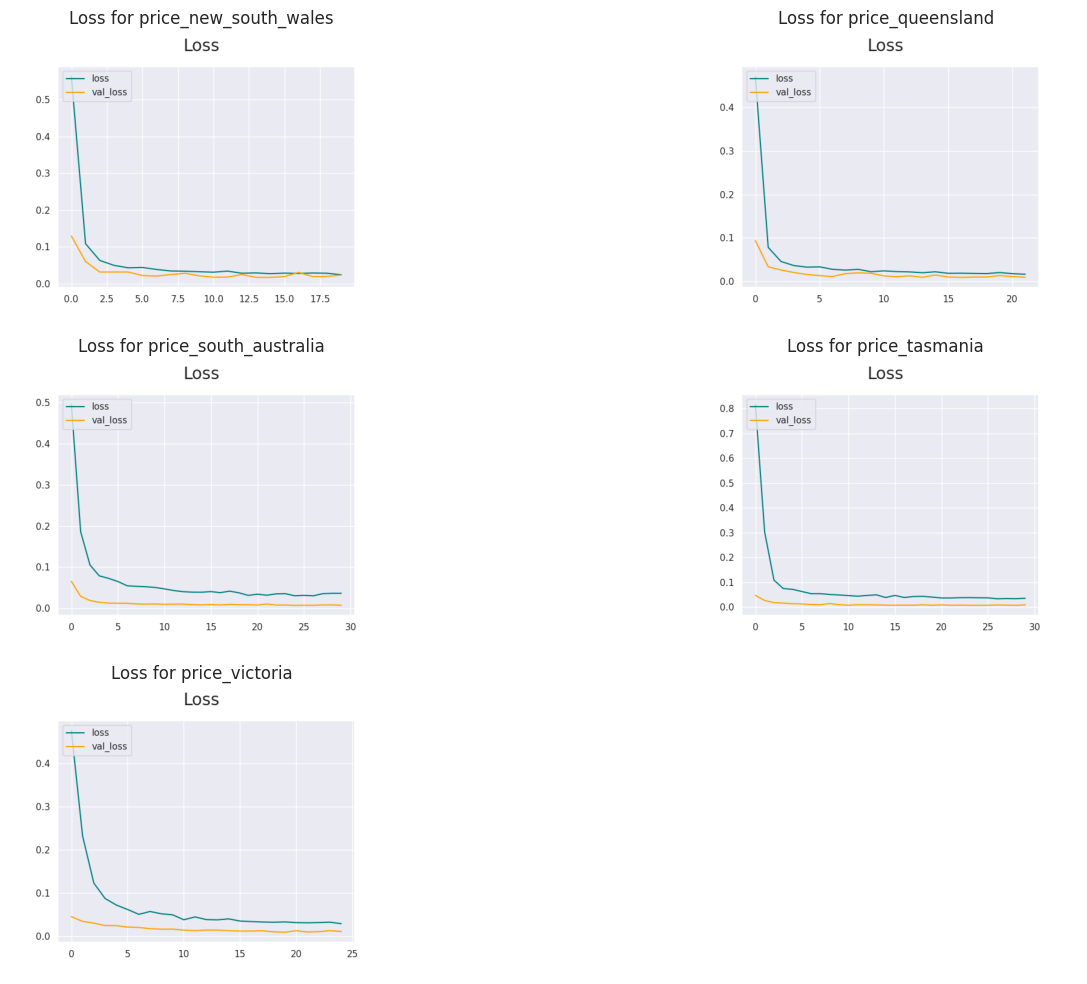

In [16]:

num_cols = 2 
num_rows = (len(df.columns[1:]) + num_cols - 1) // num_cols  

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

for i, col_to_predict in enumerate(df.columns[1:]):
    row = i // num_cols
    col = i % num_cols

    # Load the saved loss plot
    loss_plot_path = f'loss_plot_{col_to_predict}.png'
    loss_plot = plt.imread(loss_plot_path)

    axs[row, col].imshow(loss_plot)
    axs[row, col].axis('off')
    axs[row, col].set_title(f'Loss for {col_to_predict}')


for i in range(len(df.columns[1:]), num_cols * num_rows):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()


<p style="text-align:center; font-size:24px; font-weight:bold;">Model prediction</p>

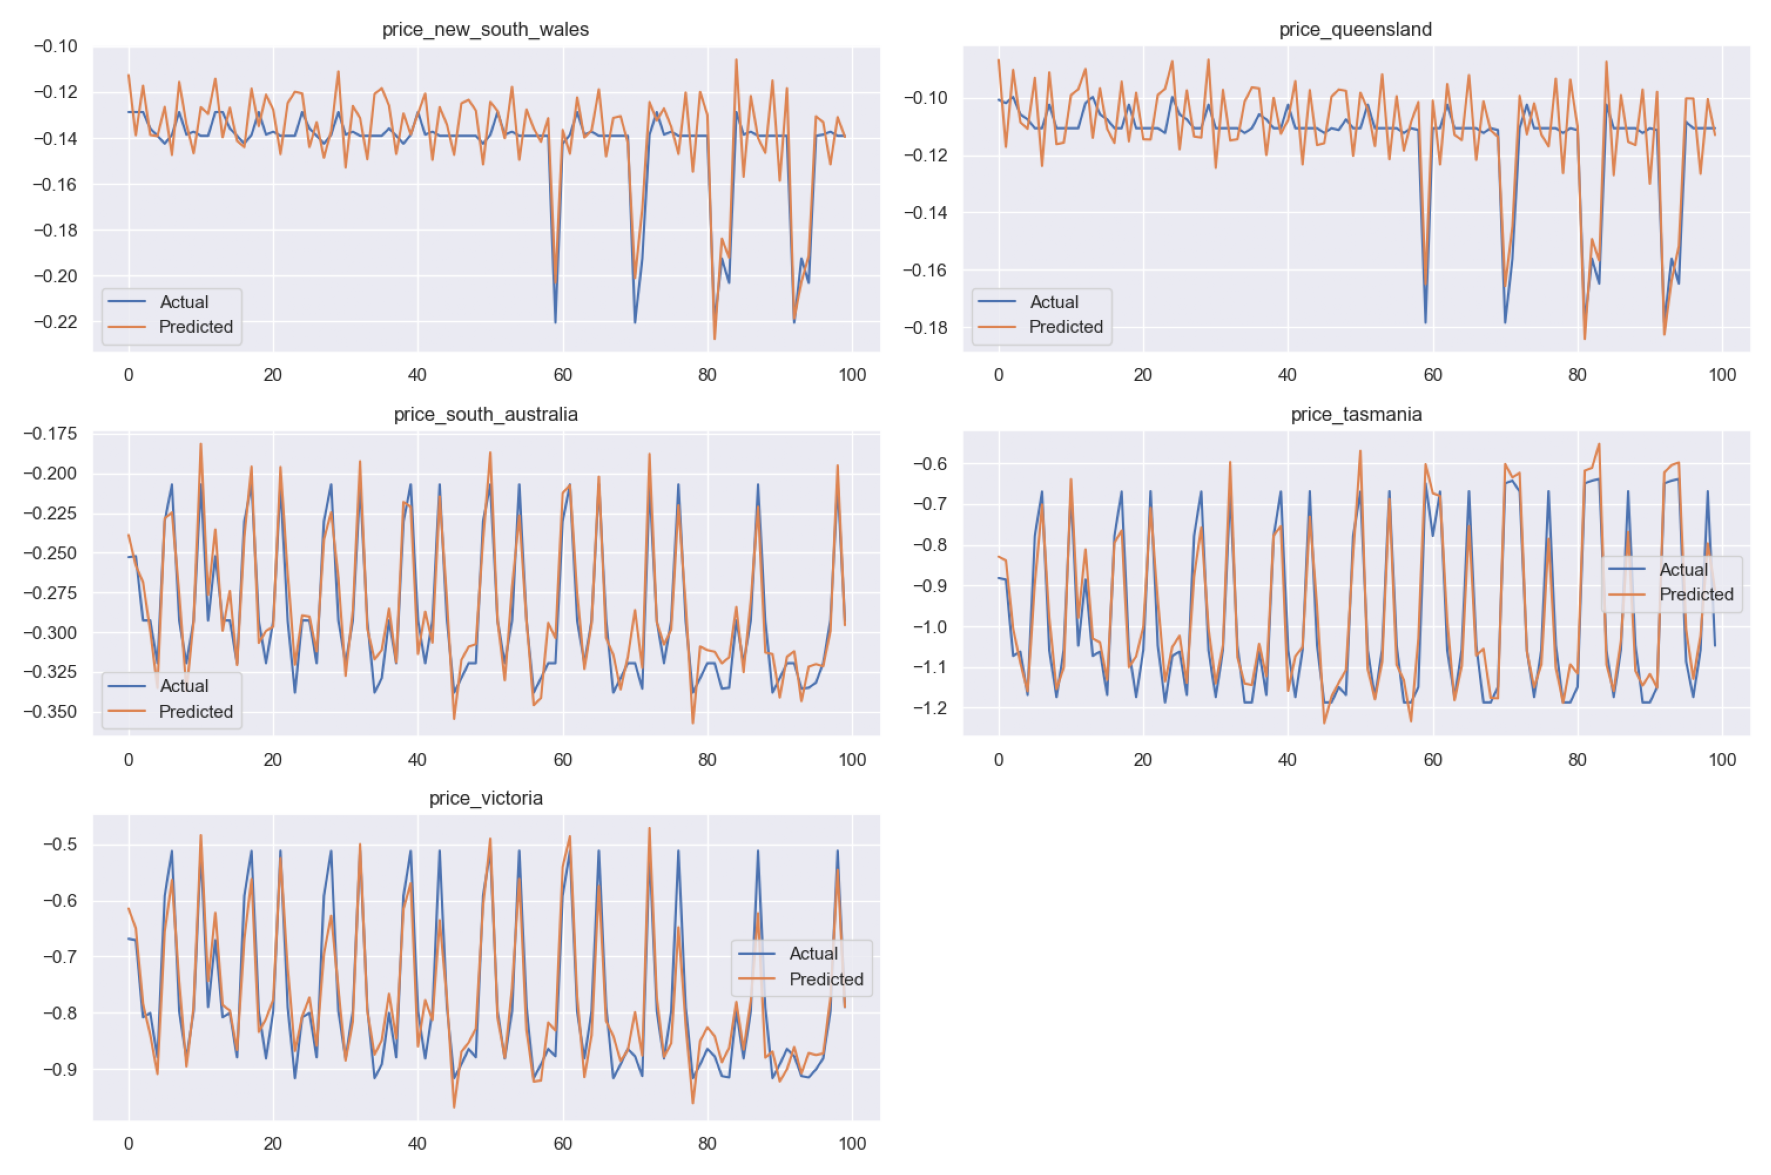

In [2]:
num_cols = 2  
num_rows = (len(df.columns[1:]) + num_cols - 1) // num_cols  

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

for i, col_to_predict in enumerate(df.columns[1:]):
    row = i // num_cols
    col = i % num_cols

    y_pred = model.predict(xtest_dict[col_to_predict])

    axs[row, col].plot(ytest_dict[col_to_predict].flatten()[:100], label='Actual')
    axs[row, col].plot(y_pred.flatten()[:100], label='Predicted')
    axs[row, col].set_title(col_to_predict)
    axs[row, col].legend()


for i in range(len(df.columns[1:]), num_cols * num_rows):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()



i tried to plot the actual vs the predicted but plotting 1 hour represented as 12 values not only onee value

820/820 [==============================] - 2s 2ms/step


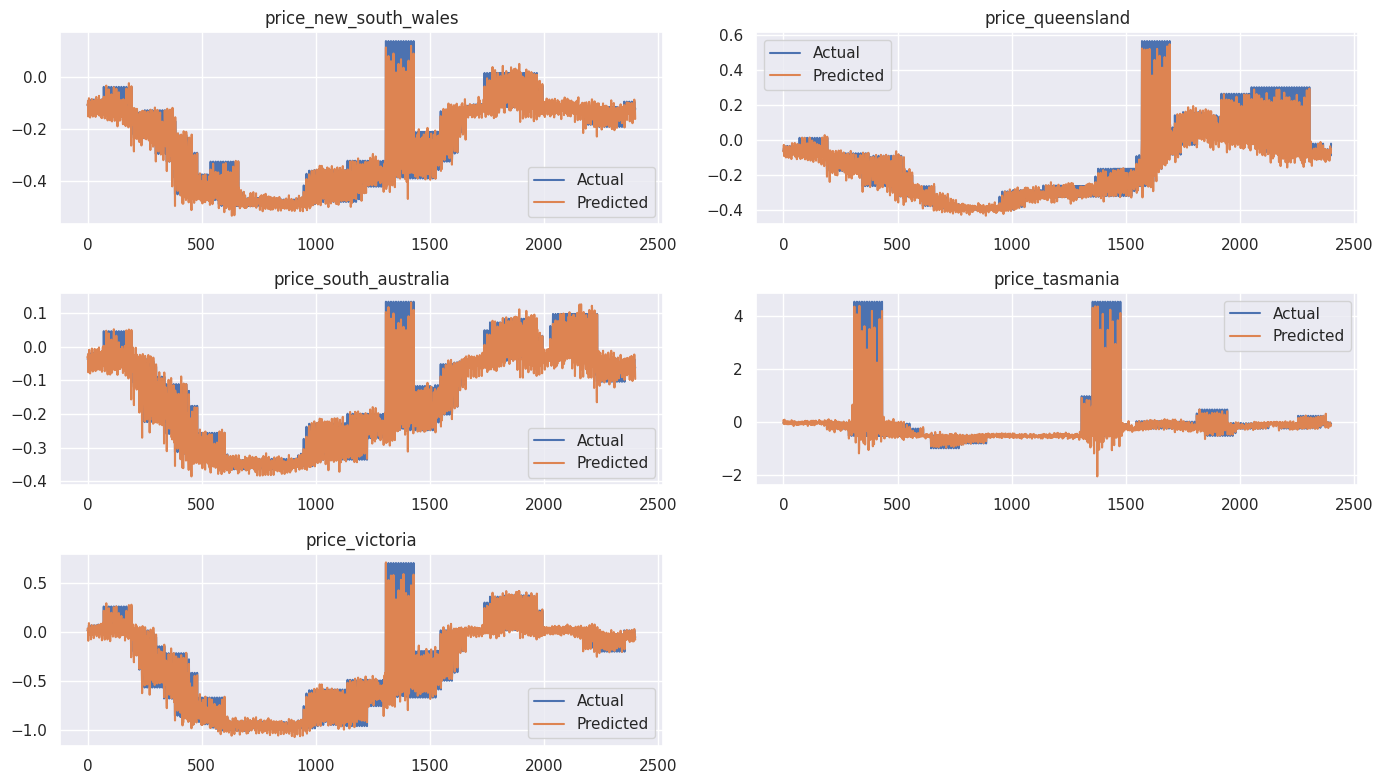

In [19]:

num_cols = 2  
num_rows = (len(df.columns[1:]) + num_cols - 1) // num_cols  

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(14, 8))

for i, col_to_predict in enumerate(df.columns[1:]):
    row = i // num_cols
    col = i % num_cols

    y_pred = model.predict(xtest_dict[col_to_predict])

    axs[row, col].plot(ytest_dict[col_to_predict].reshape(-1,12,1)[1200:1400].flatten(), label='Actual')
    axs[row, col].plot(y_pred.reshape(-1,12,1)[1200:1400].flatten(), label='Predicted')
    axs[row, col].set_title(col_to_predict)
    axs[row, col].legend()


for i in range(len(df.columns[1:]), num_cols * num_rows):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

<p style="text-align:center; font-size:24px; font-weight:bold;">Modem Mean Squared Error</p>

In [20]:
from sklearn.metrics import mean_squared_error

# Dictionary to store MSE for each state
gru_mse_dict = {}

# Loop over all states
for col_to_predict in df.columns[1:]:
    print(f"Training model for {col_to_predict}...")


    y_pred = model.predict(xtest_dict[col_to_predict])


    mse = mean_squared_error(ytest_dict[col_to_predict], y_pred)
    gru_mse_dict[col_to_predict] = mse

    print(f'Mean Squared Error for {col_to_predict}: {mse}')

Training model for price_new_south_wales...
820/820 [==============================] - 2s 3ms/step
Mean Squared Error for price_new_south_wales: 0.03666291816245697
Training model for price_queensland...
820/820 [==============================] - 2s 2ms/step
Mean Squared Error for price_queensland: 0.08644288976880705
Training model for price_south_australia...
820/820 [==============================] - 2s 2ms/step
Mean Squared Error for price_south_australia: 0.05735128261915252
Training model for price_tasmania...
820/820 [==============================] - 2s 2ms/step
Mean Squared Error for price_tasmania: 0.0077448148392505155
Training model for price_victoria...
820/820 [==============================] - 2s 2ms/step
Mean Squared Error for price_victoria: 0.009120422855623438


<p style="text-align:center; font-size:40px; font-weight:bold;">LSTM Model</p>

In [21]:
for col_to_predict in df.columns[1:]:  
    print(f"Training model for {col_to_predict}...")
    model = lstm(history, future)

    
    hist_gru = model.fit(xtrain_dict_split[col_to_predict], ytrain_dict_split[col_to_predict],
                         epochs=100, batch_size=64, verbose=1, validation_split=0.1,
                         callbacks=[EarlyStopping(monitor="val_loss", patience=10)])

    print("Training completed. Plotting and saving graphs...")

    
    fig = plt.figure()
    plt.plot(hist_gru.history['loss'], color='teal', label='loss')
    plt.plot(hist_gru.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.savefig(f'loss_plot_{col_to_predict}.png')
    plt.close()


    print(f"Graphs saved for {col_to_predict}.")
print("Training completed for all states. Plotting combined results...")

Training model for price_new_south_wales...
Epoch 1/100
1106/1106 [==============================] - 17s 13ms/step - loss: 0.8127 - val_loss: 0.4102
Epoch 2/100
1106/1106 [==============================] - 15s 14ms/step - loss: 0.5417 - val_loss: 0.2225
Epoch 3/100
1106/1106 [==============================] - 14s 13ms/step - loss: 0.4502 - val_loss: 0.1768
Epoch 4/100
1106/1106 [==============================] - 13s 12ms/step - loss: 0.3885 - val_loss: 0.1329
Epoch 5/100
1106/1106 [==============================] - 14s 12ms/step - loss: 0.3668 - val_loss: 0.1310
Epoch 6/100
1106/1106 [==============================] - 13s 12ms/step - loss: 0.3529 - val_loss: 0.1142
Epoch 7/100
1106/1106 [==============================] - 14s 12ms/step - loss: 0.3406 - val_loss: 0.1067
Epoch 8/100
1106/1106 [==============================] - 15s 13ms/step - loss: 0.3360 - val_loss: 0.0987
Epoch 9/100
1106/1106 [==============================] - 14s 12ms/step - loss: 0.2971 - val_loss: 0.1063
Epoch 10/10

<p style="text-align:center; font-size:34px; font-weight:bold;">Loss evolution</p>

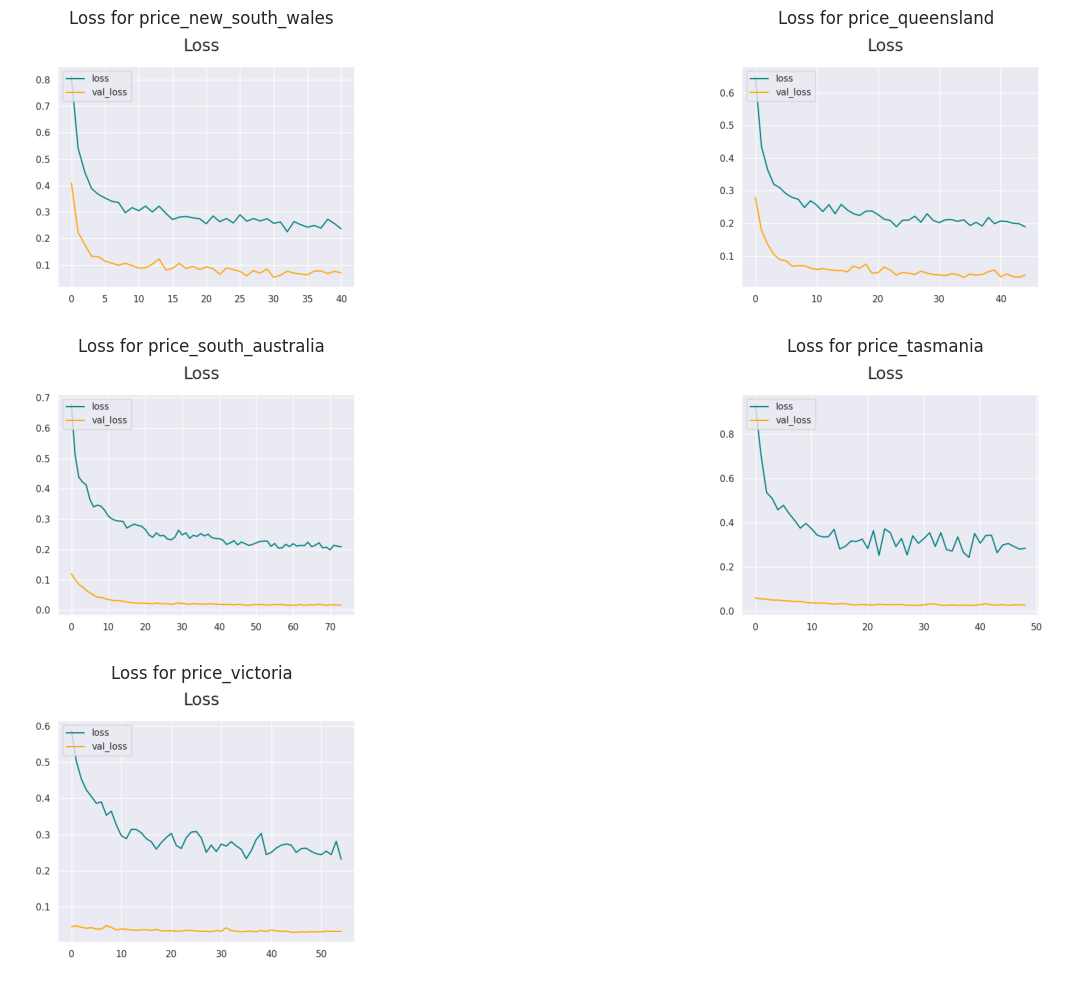

In [22]:
x
num_cols = 2  
num_rows = (len(df.columns[1:]) + num_cols - 1) // num_cols 

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

for i, col_to_predict in enumerate(df.columns[1:]):
    row = i // num_cols
    col = i % num_cols


    loss_plot_path = f'loss_plot_{col_to_predict}.png'
    loss_plot = plt.imread(loss_plot_path)

    axs[row, col].imshow(loss_plot)
    axs[row, col].axis('off')
    axs[row, col].set_title(f'Loss for {col_to_predict}')


for i in range(len(df.columns[1:]), num_cols * num_rows):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

<p style="text-align:center; font-size:34px; font-weight:bold;">Model Predictions </p>

820/820 [==============================] - 3s 4ms/step


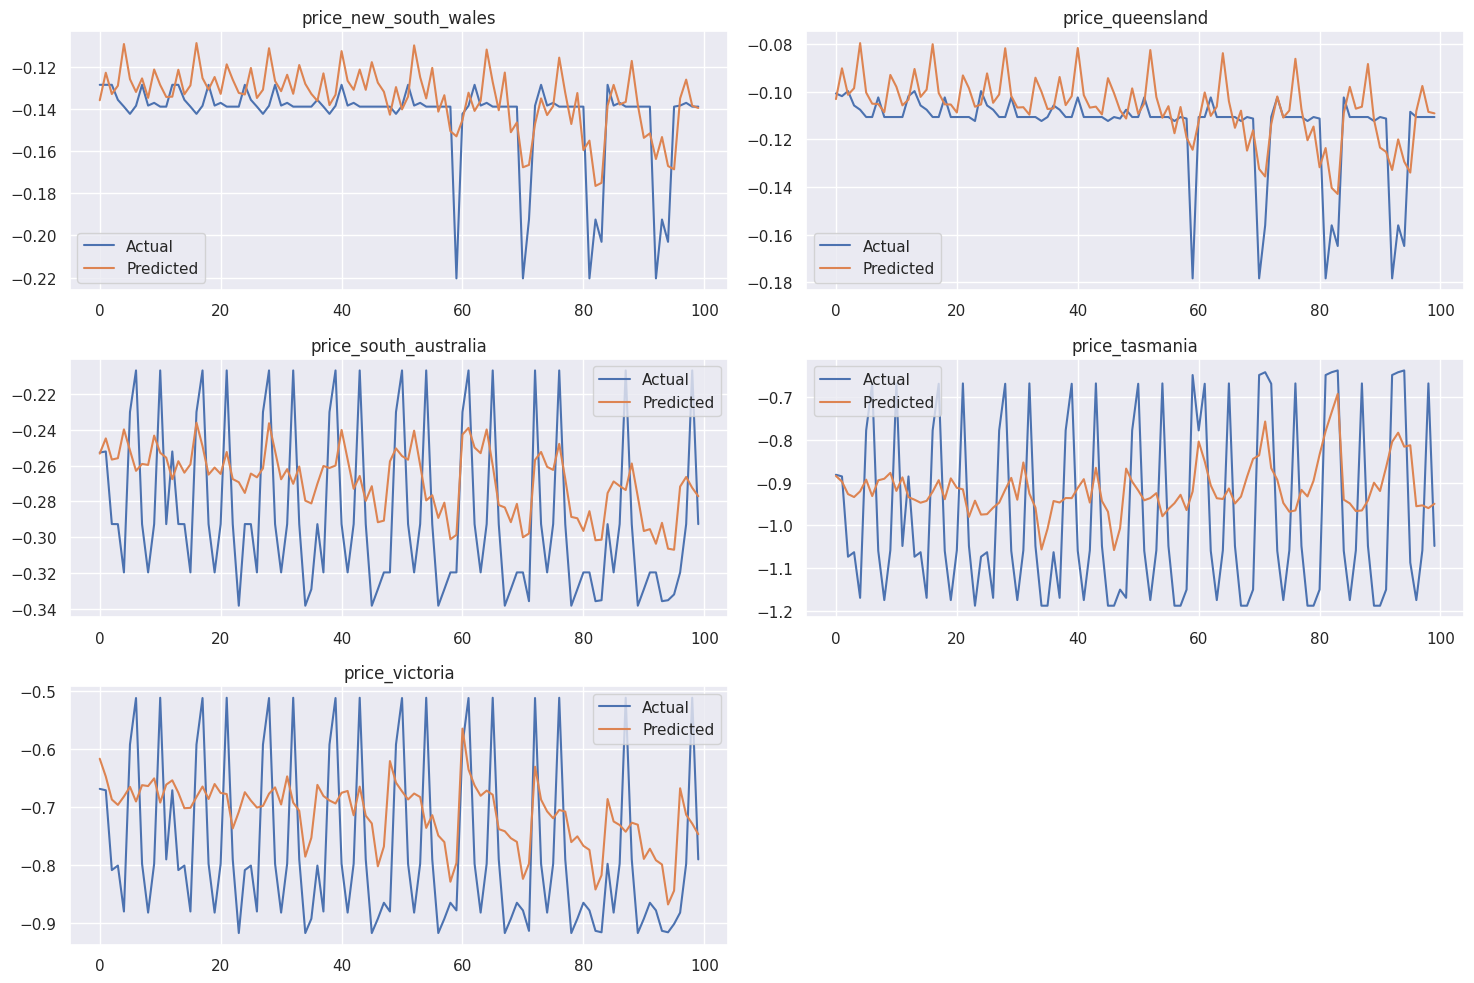

In [23]:

num_cols = 2  
num_rows = (len(df.columns[1:]) + num_cols - 1) // num_cols 

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

for i, col_to_predict in enumerate(df.columns[1:]):
    row = i // num_cols
    col = i % num_cols

    y_pred = model.predict(xtest_dict[col_to_predict])

    axs[row, col].plot(ytest_dict[col_to_predict].flatten()[:100], label='Actual')
    axs[row, col].plot(y_pred.flatten()[:100], label='Predicted')
    axs[row, col].set_title(col_to_predict)
    axs[row, col].legend()


for i in range(len(df.columns[1:]), num_cols * num_rows):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

<p style="text-align:center; font-size:34px; font-weight:bold;">Mse for each state</p>

In [24]:
from sklearn.metrics import mean_squared_error


lstm_mse_dict = {}


for col_to_predict in df.columns[1:]:
    print(f"Training model for {col_to_predict}...")



    y_pred = model.predict(xtest_dict[col_to_predict])


    mse = mean_squared_error(ytest_dict[col_to_predict], y_pred)
    lstm_mse_dict[col_to_predict] = mse

    print(f'Mean Squared Error for {col_to_predict}: {mse}')

Training model for price_new_south_wales...
820/820 [==============================] - 2s 3ms/step
Mean Squared Error for price_new_south_wales: 0.11229038110857863
Training model for price_queensland...
820/820 [==============================] - 3s 3ms/step
Mean Squared Error for price_queensland: 0.2627175402049065
Training model for price_south_australia...
820/820 [==============================] - 3s 3ms/step
Mean Squared Error for price_south_australia: 0.16153865993752306
Training model for price_tasmania...
820/820 [==============================] - 3s 3ms/step
Mean Squared Error for price_tasmania: 0.02873355489129425
Training model for price_victoria...
820/820 [==============================] - 4s 5ms/step
Mean Squared Error for price_victoria: 0.024637757457600915


<p style="text-align:center; font-size:40px; font-weight:bold;">CNN Model</p>
<p style="text-align:center;">Tried to fit a CNN layer to copare results

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

shape = xtrain_dict_split["price_new_south_wales"].reshape(-1,288,1).shape[1:]
def cnn(history, future):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(shape)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(.3))
    model.add(Flatten())
    model.add(Dense(future))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


for col_to_predict in df.columns[1:]:
    print(f"Training model for {col_to_predict} using CNN...")

    model = cnn(history, future)

    X ,Y= xtrain_dict_split[col_to_predict].reshape(-1,288,1), ytrain_dict_split[col_to_predict].reshape(-1,12,1)


    hist_cnn = model.fit(X,Y,
                         epochs=100, batch_size=32, verbose=1, validation_split=0.1,
                         callbacks=[EarlyStopping(monitor="val_loss", patience=10)])

    print("Training completed. Plotting and saving graphs...")


    fig = plt.figure()
    plt.plot(hist_cnn.history['loss'], color='teal', label='loss')
    plt.plot(hist_cnn.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.savefig(f'loss_plot_cnn_{col_to_predict}.png')
    plt.close()


Training model for price_new_south_wales using CNN...
Epoch 1/15
2212/2212 [==============================] - 33s 14ms/step - loss: 0.7990 - val_loss: 0.4863
Epoch 2/15
2212/2212 [==============================] - 30s 13ms/step - loss: 0.5928 - val_loss: 0.3663
Epoch 3/15
2212/2212 [==============================] - 30s 13ms/step - loss: 0.5087 - val_loss: 0.3017
Epoch 4/15
2212/2212 [==============================] - 31s 14ms/step - loss: 0.4375 - val_loss: 0.2581
Epoch 5/15
2212/2212 [==============================] - 29s 13ms/step - loss: 0.4085 - val_loss: 0.2425
Epoch 6/15
2212/2212 [==============================] - 30s 13ms/step - loss: 0.3888 - val_loss: 0.2172
Epoch 7/15
2212/2212 [==============================] - 30s 14ms/step - loss: 0.3758 - val_loss: 0.2375
Epoch 8/15
2212/2212 [==============================] - 29s 13ms/step - loss: 0.3556 - val_loss: 0.2056
Epoch 9/15
2212/2212 [==============================] - 29s 13ms/step - loss: 0.3364 - val_loss: 0.1915
Epoch 10/1

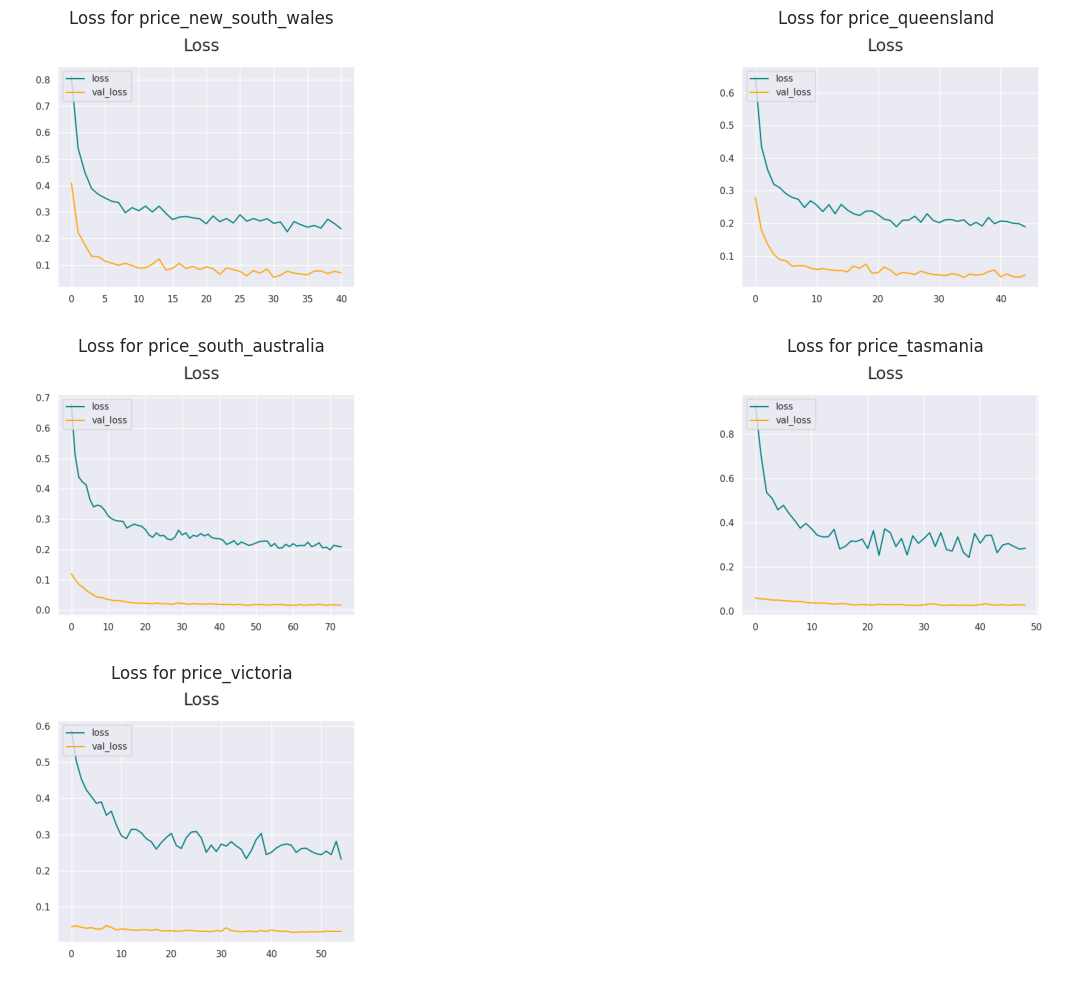

In [27]:
num_cols = 2  
num_rows = (len(df.columns[1:]) + num_cols - 1) // num_cols  

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

for i, col_to_predict in enumerate(df.columns[1:]):
    row = i // num_cols
    col = i % num_cols


    loss_plot_path = f'loss_plot_{col_to_predict}.png'
    loss_plot = plt.imread(loss_plot_path)

    axs[row, col].imshow(loss_plot)
    axs[row, col].axis('off')
    axs[row, col].set_title(f'Loss for {col_to_predict}')


for i in range(len(df.columns[1:]), num_cols * num_rows):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

820/820 [==============================] - 3s 4ms/step


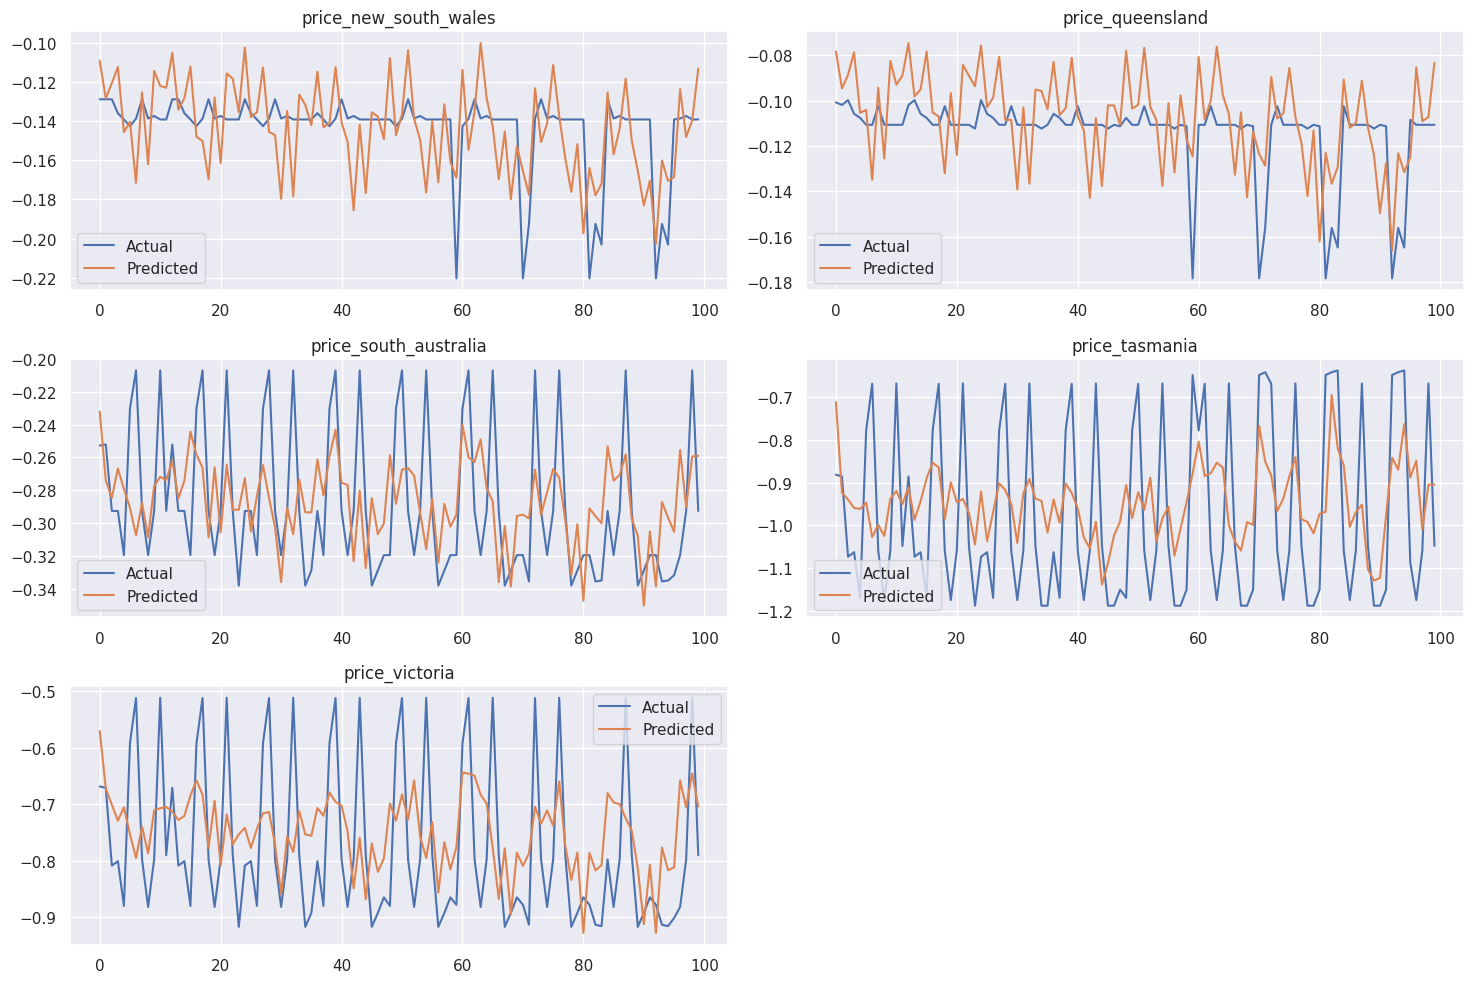

In [28]:

num_cols = 2  
num_rows = (len(df.columns[1:]) + num_cols - 1) // num_cols 

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

for i, col_to_predict in enumerate(df.columns[1:]):
    row = i // num_cols
    col = i % num_cols

    y_pred = model.predict(xtest_dict[col_to_predict].reshape(-1,288,1))

    axs[row, col].plot(ytest_dict[col_to_predict].reshape(-1,12,1).flatten()[:100], label='Actual')
    axs[row, col].plot(y_pred.flatten()[:100], label='Predicted')
    axs[row, col].set_title(col_to_predict)
    axs[row, col].legend()


for i in range(len(df.columns[1:]), num_cols * num_rows):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error


cnn_mse_dict = {}

for col_to_predict in df.columns[1:]:


    y_pred = model.predict(xtest_dict[col_to_predict].reshape(-1,288,1))


    mse = mean_squared_error(ytest_dict[col_to_predict], y_pred)
    cnn_mse_dict[col_to_predict] = mse

    print(f'Mean Squared Error for {col_to_predict}: {mse}')

820/820 [==============================] - 4s 5ms/step
Mean Squared Error for price_new_south_wales: 0.16944719683252865
820/820 [==============================] - 6s 7ms/step
Mean Squared Error for price_queensland: 0.3347136706764662
820/820 [==============================] - 5s 6ms/step
Mean Squared Error for price_south_australia: 0.16481609873085656
820/820 [==============================] - 6s 7ms/step
Mean Squared Error for price_tasmania: 0.027854182227540172
820/820 [==============================] - 5s 6ms/step
Mean Squared Error for price_victoria: 0.023077272172141963


<p style="text-align:center; font-size:24px; font-weight:bold;">Model Comparaison</p>

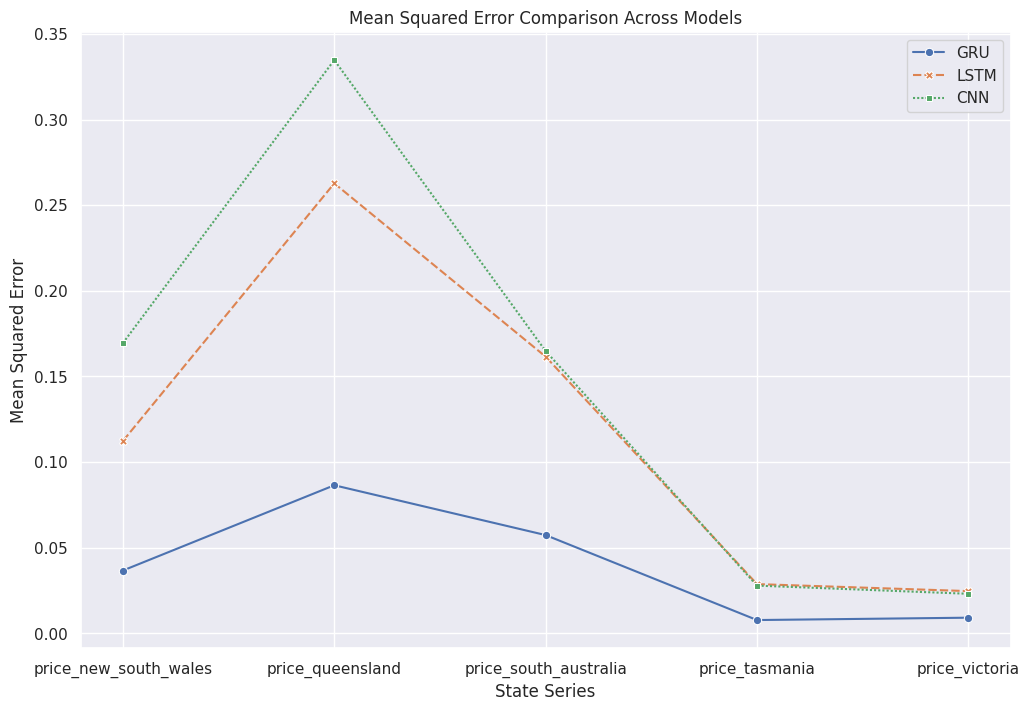

In [30]:
mse_data = pd.DataFrame({
    'GRU': list(gru_mse_dict.values()),
    'LSTM': list(lstm_mse_dict.values()),
    'CNN': list(cnn_mse_dict.values())
}, index=list(gru_mse_dict.keys()))


sns.set(style="darkgrid")
plt.figure(figsize=(12, 8))
sns.lineplot(data=mse_data, markers=True)
plt.title('Mean Squared Error Comparison Across Models')
plt.xlabel('State Series')
plt.ylabel('Mean Squared Error')
plt.show()

<Figure size 1200x800 with 0 Axes>

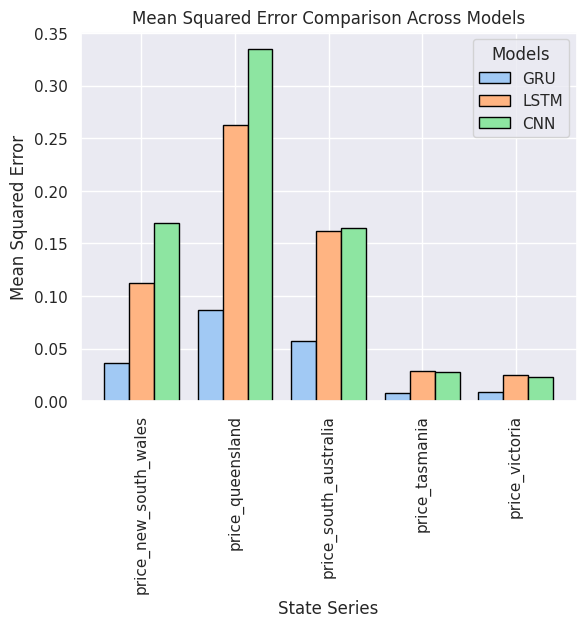

In [31]:

mse_data = pd.DataFrame({
    'GRU': list(gru_mse_dict.values()),
    'LSTM': list(lstm_mse_dict.values()),
    'CNN': list(cnn_mse_dict.values())
}, index=list(gru_mse_dict.keys()))


colors = sns.color_palette("pastel")

plt.figure(figsize=(12, 8))
mse_data.plot(kind='bar', width=0.8, edgecolor='black', color=colors)
plt.title('Mean Squared Error Comparison Across Models')
plt.xlabel('State Series')
plt.ylabel('Mean Squared Error')
plt.legend(title='Models')
plt.show()